In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from scipy.stats import probplot, moment
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [39]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [40]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## **Correlogram Plot & Volatility Clustering**


[*********************100%***********************]  1 of 1 completed


c:\Users\SARAN\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


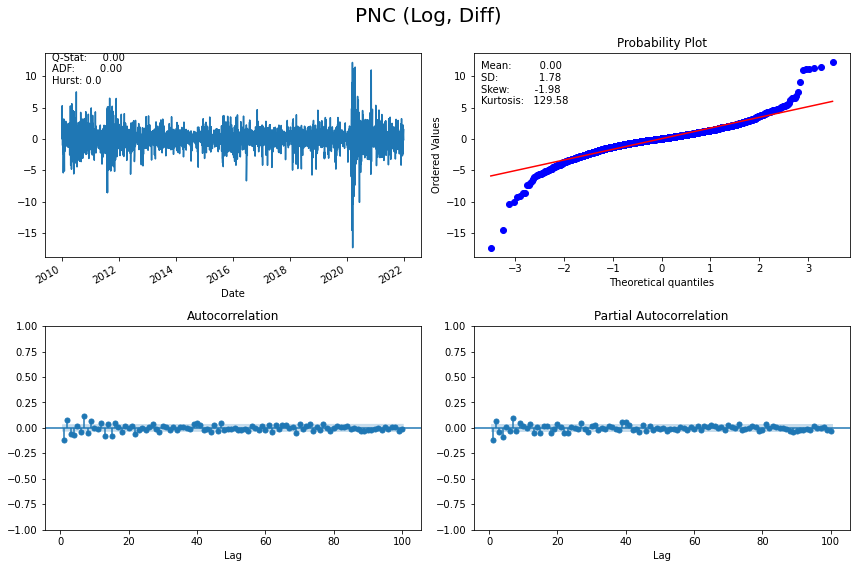

In [41]:
ticker = "PNC"
df = yf.download(ticker, start="2010-01-01", end="2021-12-31")
df['Returns'] = df['Close'].pct_change()*100
df['Log_Return'] = np.log(df['Close']).diff().mul(100) # rescale 
df.dropna(inplace=True)

plot_correlogram(df['Log_Return'], lags=100, title='PNC (Log, Diff)')


In [42]:
garch = arch_model(df['Returns'].dropna(), mean='AR', vol='GARCH', p=1, q=1)
garch_fit = garch.fit()
print(garch_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1576277372452.536
Iteration:      2,   Func. Count:     14,   Neg. LLF: 34257.40941485318
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6573.5321105230005
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6139.588365312685
Iteration:      5,   Func. Count:     38,   Neg. LLF: 5462.684167293905
Iteration:      6,   Func. Count:     44,   Neg. LLF: 5452.974586075814
Iteration:      7,   Func. Count:     49,   Neg. LLF: 5452.96568542969
Iteration:      8,   Func. Count:     54,   Neg. LLF: 5452.963980109035
Iteration:      9,   Func. Count:     59,   Neg. LLF: 5452.963908372864
Iteration:     10,   Func. Count:     64,   Neg. LLF: 5452.963902615871
Iteration:     11,   Func. Count:     68,   Neg. LLF: 5452.963902616428
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5452.963902615871
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11

In [43]:
forecasts = garch_fit.forecast(horizon=10)
volatility = forecasts.variance

c:\Users\SARAN\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


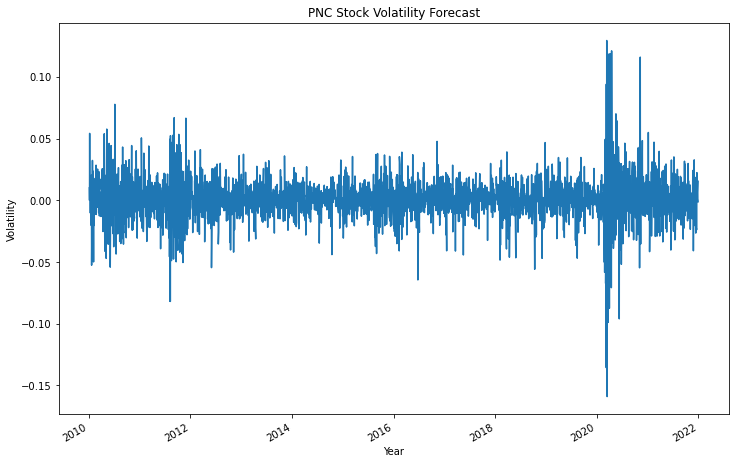

In [30]:
df['Returns'].plot(figsize=(12, 8))
plt.plot(volatility, color='red')
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.title(f"{ticker} Stock Volatility Forecast")
plt.show()

In [48]:
print(forecasts.variance[-1:])

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2021-12-30  1.766471  1.802566  1.837075  1.870068  1.901611  1.931769   

                h.07      h.08      h.09      h.10  
Date                                                
2021-12-30  1.960602  1.988167  2.014522  2.039719  
